# Installations

In [1]:
#pip install association_metrics

In [2]:
#pip install pyod
#pip install dython

# Importing Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import association_metrics as am
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from dython.nominal import associations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score,classification_report,mean_squared_error
from pyod.models.knn import KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from scikitplot.metrics import plot_cumulative_gain as pcg
from imblearn.over_sampling import SMOTE

# Reading and checking data 

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Describe the Data

In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
df.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,0384-LPITE,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


# Checking for Null value

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Dropping Customer ID column as not required

In [10]:
df.drop('customerID',axis=1,inplace=True)

In [11]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [12]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [13]:
df.dropna(axis=0,inplace=True)
df.shape

(7032, 20)

In [14]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Checking the Target Value

In [15]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [16]:
count_zero = (df['Churn'].value_counts()[0]/len(df['Churn']))*100
count_zero

73.42150170648463

In [17]:
count_one = (df['Churn'].value_counts()[1]/len(df['Churn']))*100
count_one

26.578498293515356

# Checking Collinearity in the data 

In [18]:
df = df.apply(
    lambda x : x.astype('category') if x.dtype == 'O' else x
)

cramers_v = am.CramersV(df)

cfit = cramers_v.fit().round(2)
cfit

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
gender,1.00,0.00,0.01,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.01
Partner,0.00,1.00,0.45,0.02,0.14,0.00,0.15,0.15,0.17,0.13,0.14,0.13,0.30,0.01,0.16,0.15
Dependents,0.01,0.45,1.00,0.00,0.03,0.18,0.19,0.16,0.16,0.18,0.15,0.14,0.24,0.11,0.15,0.16
PhoneService,0.01,0.02,0.00,1.00,1.00,0.45,0.18,0.17,0.17,0.18,0.18,0.18,0.00,0.02,0.01,0.01
MultipleLines,0.01,0.14,0.03,1.00,1.00,0.40,0.23,0.25,0.25,0.23,0.26,0.26,0.08,0.17,0.17,0.04
InternetService,0.01,0.00,0.18,0.45,0.40,1.00,0.72,0.71,0.71,0.72,0.72,0.72,0.21,0.38,0.31,0.32
OnlineSecurity,0.02,0.15,0.19,0.18,0.23,0.72,1.00,0.72,0.72,0.73,0.71,0.71,0.30,0.34,0.30,0.35
OnlineBackup,0.01,0.15,0.16,0.17,0.25,0.71,0.72,1.00,0.72,0.72,0.71,0.71,0.26,0.32,0.28,0.29
DeviceProtection,0.00,0.17,0.16,0.17,0.25,0.71,0.72,0.72,1.00,0.73,0.73,0.74,0.30,0.32,0.29,0.28
TechSupport,0.01,0.13,0.18,0.18,0.23,0.72,0.73,0.72,0.73,1.00,0.72,0.72,0.33,0.33,0.31,0.34


In [19]:
#associations(df, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', nan_strategy='drop_samples', ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, cbar=True, vmax=1.0, vmin=None, plot=True, title='Correlation of entire dataset')

In [20]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


In [21]:
categorical_cols = df.select_dtypes(exclude = np.number).columns.tolist()
numerical_cols = df.select_dtypes(include = np.number).columns.tolist()

In [22]:
length= len(categorical_cols)

In [23]:
df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [24]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   category
 1   SeniorCitizen     7032 non-null   int64   
 2   Partner           7032 non-null   category
 3   Dependents        7032 non-null   category
 4   tenure            7032 non-null   int64   
 5   PhoneService      7032 non-null   category
 6   MultipleLines     7032 non-null   category
 7   InternetService   7032 non-null   category
 8   OnlineSecurity    7032 non-null   category
 9   OnlineBackup      7032 non-null   category
 10  DeviceProtection  7032 non-null   category
 11  TechSupport       7032 non-null   category
 12  StreamingTV       7032 non-null   category
 13  StreamingMovies   7032 non-null   category
 14  Contract          7032 non-null   category
 15  PaperlessBilling  7032 non-null   category
 16  PaymentMethod     7032 n

In [26]:
df['Churn'] = df.Churn.map({'No':0,'Yes':1})
df['Churn'] = df['Churn'].astype('int64')

In [27]:
features = df.drop('Churn',axis=1)
tg = df['Churn']

for i in features:
    if df[i].dtypes == 'category':
        woe = (pd.crosstab(df[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        print(woe)

Churn          0         1       woe        iv
gender                                        
Female  0.492737  0.502408  0.019437  0.000374
Male    0.507263  0.497592 -0.019249  0.000374
Churn         0         1       woe        iv
Partner                                      
No       0.4724  0.642055  0.306848  0.117877
Yes      0.5276  0.357945 -0.387958  0.117877
Churn              0         1       woe        iv
Dependents                                        
No          0.656595  0.825575  0.229013  0.153169
Yes         0.343405  0.174425 -0.677417  0.153169
Churn               0         1       woe        iv
PhoneService                                       
No            0.09878  0.090958 -0.082498  0.000713
Yes           0.90122  0.909042  0.008642  0.000713
Churn                    0         1       woe        iv
MultipleLines                                           
No                0.491187  0.454254 -0.078170  0.008169
No phone service  0.098780  0.090958 -0.08249

# Dummification of the Multiclass Categorical fields

In [28]:
for i in features:
    if df[i].dtypes == 'category':
        woe = (pd.crosstab(df[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        woe_dict = woe['woe'].to_dict()
        df = df.replace({i: woe_dict})

In [29]:
df.head(20)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.019437,0,-0.387958,0.229013,1,-0.082498,-0.082498,-0.434003,0.684248,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,29.85,29.85,0
1,-0.019249,0,0.306848,0.229013,34,0.008642,-0.078170,-0.434003,-0.746990,0.608219,-0.218397,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.420824,56.95,1889.50,0
2,-0.019249,0,0.306848,0.229013,2,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,-0.420824,53.85,108.15,1
3,-0.019249,0,0.306848,0.229013,45,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,-0.218397,-0.703190,0.332031,0.340714,-1.046622,-0.614421,-0.588662,42.30,1840.75,0
4,0.019437,0,0.306848,0.229013,2,0.008642,-0.078170,0.688937,0.684248,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,0.334461,0.826969,70.70,151.65,1
5,0.019437,0,0.306848,0.229013,8,0.008642,0.103595,0.688937,0.684248,0.608219,-0.218397,0.678852,0.174272,0.166549,0.722408,0.334461,0.826969,99.65,820.50,1
6,-0.019249,0,0.306848,-0.677417,22,0.008642,0.103595,0.688937,0.684248,-0.274966,0.574694,0.678852,0.174272,0.340714,0.722408,0.334461,-0.698770,89.10,1949.40,0
7,0.019437,0,0.306848,0.229013,10,-0.082498,-0.082498,-0.434003,-0.746990,0.608219,0.574694,0.678852,0.332031,0.340714,0.722408,-0.614421,-0.420824,29.75,301.90,0
8,0.019437,0,-0.387958,0.229013,28,0.008642,0.103595,0.688937,0.684248,0.608219,-0.218397,-0.703190,0.174272,0.166549,0.722408,0.334461,0.826969,104.80,3046.05,1
9,-0.019249,0,0.306848,-0.677417,62,0.008642,-0.078170,-0.434003,-0.746990,-0.274966,0.574694,0.678852,0.332031,0.340714,-1.046622,-0.614421,-0.588662,56.15,3487.95,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   float64
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   float64
 3   Dependents        7032 non-null   float64
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   float64
 6   MultipleLines     7032 non-null   float64
 7   InternetService   7032 non-null   float64
 8   OnlineSecurity    7032 non-null   float64
 9   OnlineBackup      7032 non-null   float64
 10  DeviceProtection  7032 non-null   float64
 11  TechSupport       7032 non-null   float64
 12  StreamingTV       7032 non-null   float64
 13  StreamingMovies   7032 non-null   float64
 14  Contract          7032 non-null   float64
 15  PaperlessBilling  7032 non-null   float64
 16  PaymentMethod     7032 non-null   float64


In [31]:
#features = df.drop('Churn',axis=1)
#tg = df['Churn']

for i in features:
    if features[i].dtypes == 'category':
        woe = (pd.crosstab(features[i],tg,normalize='columns').assign(woe=lambda dfx: np.log(dfx[1] / dfx[0])).assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
        print(woe['iv'])
#woe

gender
Female    0.000374
Male      0.000374
Name: iv, dtype: float64
Partner
No     0.117877
Yes    0.117877
Name: iv, dtype: float64
Dependents
No     0.153169
Yes    0.153169
Name: iv, dtype: float64
PhoneService
No     0.000713
Yes    0.000713
Name: iv, dtype: float64
MultipleLines
No                  0.008169
No phone service    0.008169
Yes                 0.008169
Name: iv, dtype: float64
InternetService
DSL            0.615253
Fiber optic    0.615253
No             0.615253
Name: iv, dtype: float64
OnlineSecurity
No                     0.715292
No internet service    0.715292
Yes                    0.715292
Name: iv, dtype: float64
OnlineBackup
No                     0.526488
No internet service    0.526488
Yes                    0.526488
Name: iv, dtype: float64
DeviceProtection
No                     0.49761
No internet service    0.49761
Yes                    0.49761
Name: iv, dtype: float64
TechSupport
No                     0.697108
No internet service    0.697108
Yes    

# Splitting Predictors and Target

In [32]:
X = df.drop('Churn',axis=1)
y = df['Churn']

Important: PaymentMethod,StreamingMovies,StreamingTV,DeviceProtection

Suspicious: Contract,TechSupport, OnlineBackup, OnlineSecurity, InternetService

Medium: PaperlessBilling, Dependents, Partner

Weak: 

Useless: MultipleLines, PhoneService, gender

# Feature Selection

In [33]:
etr_model = ExtraTreesRegressor()
etr_model.fit(X,y)
etr_model.feature_importances_

array([0.04047383, 0.02896025, 0.03647399, 0.02841521, 0.12578183,
       0.00776495, 0.02444018, 0.04018752, 0.06015111, 0.0305652 ,
       0.029     , 0.03137854, 0.02400787, 0.02338479, 0.13458148,
       0.03295355, 0.05612087, 0.11014716, 0.13521169])

<AxesSubplot:>

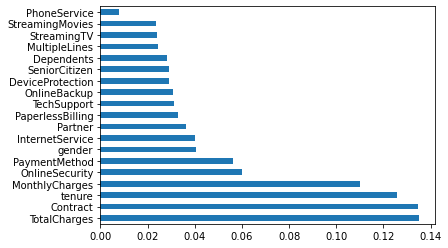

In [34]:
feature_imp = pd.Series(etr_model.feature_importances_,index=X.columns)
feature_imp.nlargest(20).plot(kind='barh')

In [35]:
feature = ['Contract','tenure','PaymentMethod','TotalCharges','MonthlyCharges','StreamingMovies','StreamingTV','DeviceProtection','TechSupport', 'OnlineBackup', 'OnlineSecurity', 'InternetService','Partner','PaperlessBilling','Dependents']

In [36]:
X = df[feature]

# Performing Train Test Split

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

# Scaling the data 

In [38]:
#sc = StandardScaler()

In [39]:
ms = MinMaxScaler()

In [40]:
X_train = pd.DataFrame(ms.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(ms.transform(X_test),columns=X_test.columns)

# Logistic regression

In [41]:
model_lr = LogisticRegression()

In [42]:
np.mean(cross_val_score(model_lr,X_train,y_train,cv=5))

0.7987555555555556

In [43]:
model_lr.fit(X_train,y_train)

LogisticRegression()

In [44]:
y_pred_lr = model_lr.predict(X_test)

In [45]:
model_lr.score(X_test,y_test)

0.7945984363894811

In [46]:
f1_score(y_test,y_pred_lr)

0.5817655571635311

In [47]:
cm = confusion_matrix(y_test,y_pred_lr)

In [48]:
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

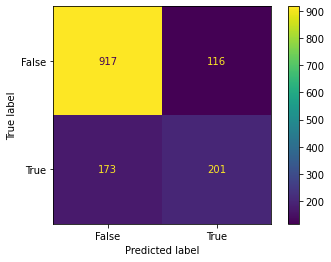

In [49]:
cm_display_lr.plot()
plt.show()

In [50]:
auc_score = roc_auc_score(y_test,y_pred_lr)
auc_score

0.7125694333000296

In [51]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



In [52]:
probs = model_lr.predict_proba(X_test)

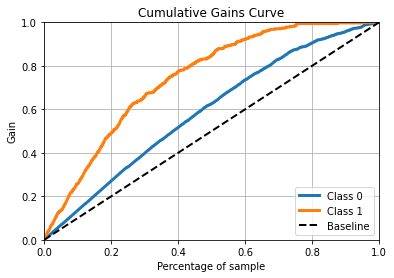

In [53]:
pcg(y_test,probs)
plt.show()

In [54]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [55]:
grid_search = GridSearchCV(model_lr, param_grid, cv=5, scoring='accuracy')

In [56]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [57]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [58]:
grid_search.best_score_

0.8

In [59]:
best_model = grid_search.best_estimator_

In [60]:
test_accuracy = best_model.score(X_test, y_test)
test_accuracy

0.7931769722814499

In [61]:
y_pred_lr1 = best_model.predict(X_test)

In [62]:
auc_score = roc_auc_score(y_test,y_pred_lr1)
auc_score

0.7056312800575654

In [63]:
print(classification_report(y_test, y_pred_lr1))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [64]:
probs_grid = best_model.predict_proba(X_test)

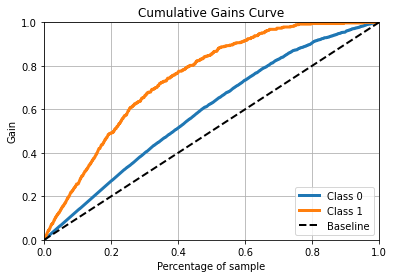

In [65]:
pcg(y_test,probs_grid)
plt.show()

# KNN Classification

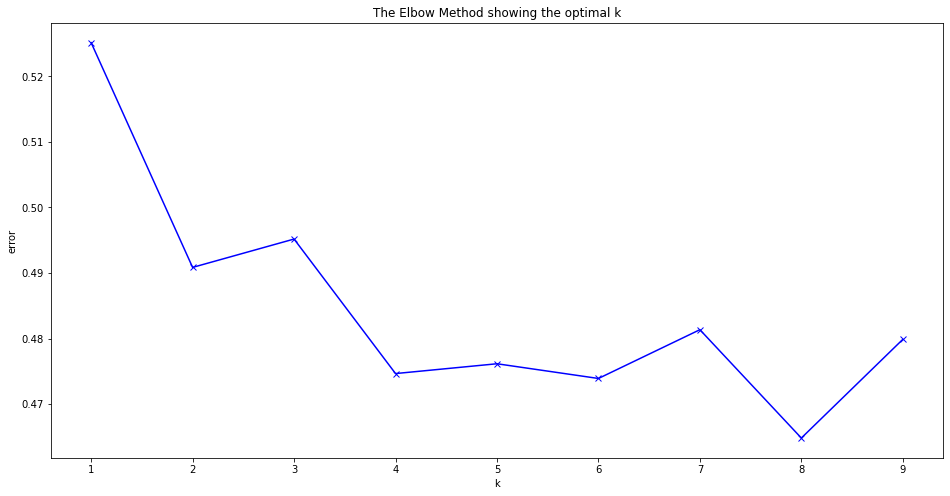

In [66]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred_KNN = knn.predict(X_test)
    error.append(np.sqrt(mean_squared_error(y_test, y_pred_KNN)))

plt.figure(figsize=(16,8))
plt.plot(range(1, 10), error, 'bx-')
plt.xlabel('k')
plt.ylabel('error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [67]:
model_knn = KNeighborsClassifier(n_neighbors = 8)

In [68]:
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=8)

In [69]:
np.mean(cross_val_score(model_knn,X_train,y_train,cv=5))

0.7744000000000001

In [70]:
y_pred_knn = model_knn.predict(X_test)

In [71]:
y_test.value_counts()

0    1033
1     374
Name: Churn, dtype: int64

In [72]:
f1_score(y_test,y_pred_knn)

0.5143769968051118

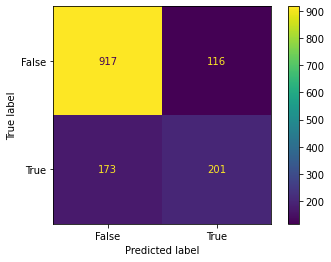

In [73]:
cm = confusion_matrix(y_test,y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [74]:
auc_score = roc_auc_score(y_test,y_pred_knn)
auc_score

0.6711941751091001

In [75]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.43      0.51       374

    accuracy                           0.78      1407
   macro avg       0.73      0.67      0.69      1407
weighted avg       0.77      0.78      0.77      1407



# DecisionTree Classification

In [76]:
model_dt = DecisionTreeClassifier(max_depth=12,max_features='log2',random_state=0)

In [77]:
np.mean(cross_val_score(model_dt,X_train,y_train,cv=5))

0.7546666666666667

In [78]:
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=12, max_features='log2', random_state=0)

In [79]:
#model_dt.get_depth()

In [80]:
y_pred_dt = model_dt.predict(X_test)

In [81]:
f1_score(y_test,y_pred_dt)

0.5520110957004162

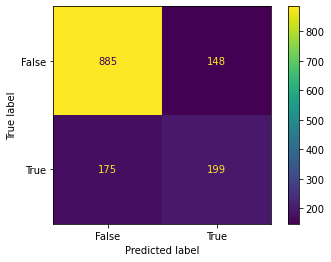

In [82]:
cm = confusion_matrix(y_test,y_pred_dt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [83]:
auc_score = roc_auc_score(y_test,y_pred_dt)
auc_score

0.6944067691320126

In [84]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1033
           1       0.57      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.70      1407
weighted avg       0.77      0.77      0.77      1407



In [85]:
probs = model_dt.predict_proba(X_test)

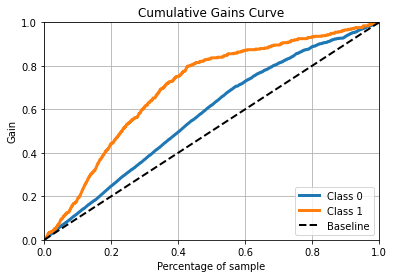

In [86]:
pcg(y_test,probs)
plt.show()

# Random Forest Classification

In [87]:
model_rf = RandomForestClassifier(max_depth=11,random_state=0)

In [88]:
np.mean(cross_val_score(model_rf,X_train,y_train,cv=5))

0.7950222222222222

In [89]:
model_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=11, random_state=0)

In [90]:
y_pred_rf = model_rf.predict(X_test)

In [91]:
f1_score(y_test,y_pred_rf)

0.561863173216885

In [92]:
auc_score = roc_auc_score(y_test,y_pred_rf)
auc_score

0.6999381377121824

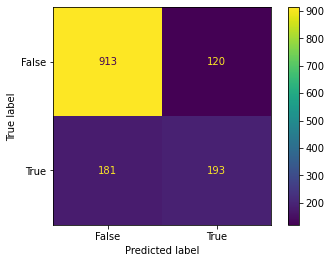

In [93]:
cm = confusion_matrix(y_test,y_pred_rf)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [94]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [95]:
probs = model_rf.predict_proba(X_test)

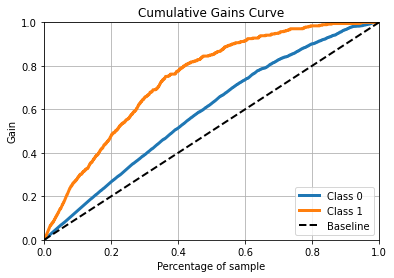

In [96]:
pcg(y_test,probs)
plt.show()

# Applying SMOTE

In [97]:
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [98]:
count_zero = (y_train.value_counts()[0]/len(y_train))*100
count_zero

50.0

In [99]:
count_one = (y_train.value_counts()[1]/len(y_train))*100
count_one

50.0

# Logistic Regression

In [100]:
model_lr_smt = LogisticRegression()

In [101]:
np.mean(cross_val_score(model_lr_smt,X_train,y_train,cv=5))

0.776997578692494

In [102]:
model_lr_smt.fit(X_train,y_train)

LogisticRegression()

In [103]:
y_pred_lr_smt = model_lr_smt.predict(X_test)

In [104]:
f1_score(y_test,y_pred_lr_smt)

0.6072538860103627

In [105]:
auc_score = roc_auc_score(y_test,y_pred_lr_smt)
auc_score

0.7474711525021872

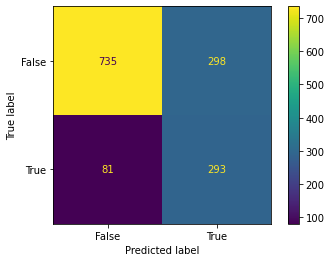

In [106]:
cm = confusion_matrix(y_test,y_pred_lr_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [107]:
print(classification_report(y_test, y_pred_lr_smt))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



In [108]:
probs = model_lr_smt.predict_proba(X_test)

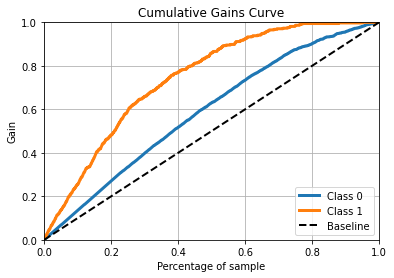

In [109]:
pcg(y_test,probs)
plt.show()

# KNN

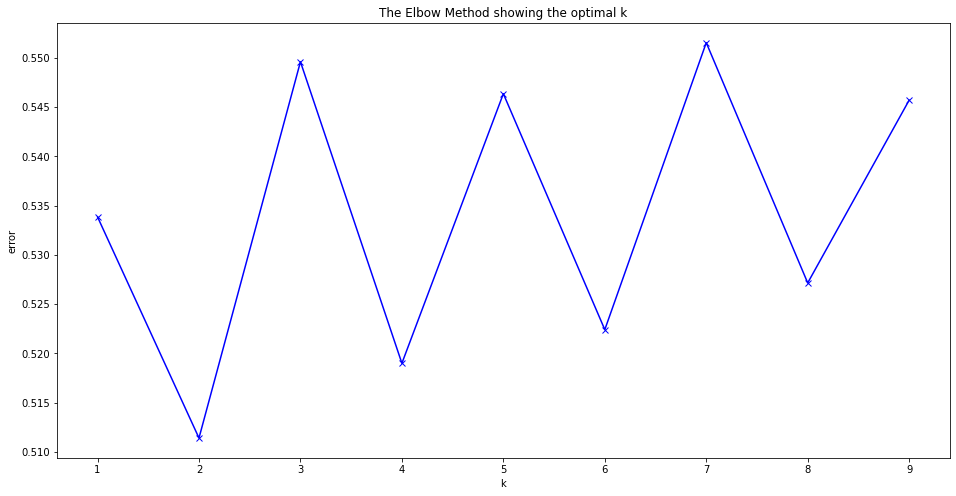

In [110]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred_KNN = knn.predict(X_test)
    error.append(np.sqrt(mean_squared_error(y_test, y_pred_KNN)))

plt.figure(figsize=(16,8))
plt.plot(range(1, 10), error, 'bx-')
plt.xlabel('k')
plt.ylabel('error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [111]:
knn_smt = KNeighborsClassifier(n_neighbors = 2)

In [112]:
knn_smt.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=2)

In [113]:
y_pred_knn_smt = knn_smt.predict(X_test)

In [114]:
f1_score(y_test,y_pred_knn_smt)

0.4757834757834758

In [115]:
auc_score = roc_auc_score(y_test,y_pred_knn_smt)
auc_score

0.6453336680971782

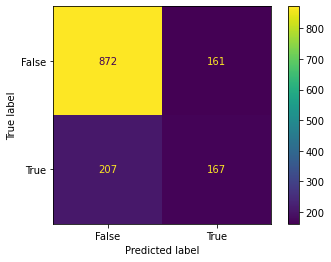

In [116]:
cm = confusion_matrix(y_test,y_pred_knn_smt)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [117]:
print(classification_report(y_test, y_pred_knn_smt))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1033
           1       0.51      0.45      0.48       374

    accuracy                           0.74      1407
   macro avg       0.66      0.65      0.65      1407
weighted avg       0.73      0.74      0.73      1407



In [118]:
probs_knn_smt = knn_smt.predict_proba(X_test)

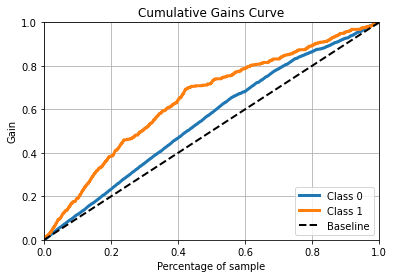

In [119]:
pcg(y_test,probs_knn_smt)
plt.show()

# Decision Tree

In [120]:
model_dt_smt = DecisionTreeClassifier(max_depth=6)

In [121]:
model_dt_smt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [122]:
model_dt_smt.get_depth()

6

In [123]:
y_pred_dt_smt = model_dt_smt.predict(X_test)

In [124]:
f1_score(y_test,y_pred_dt_smt)

0.6031390134529148

In [125]:
auc_score = roc_auc_score(y_test,y_pred_dt_smt)
auc_score

0.7391029191752385

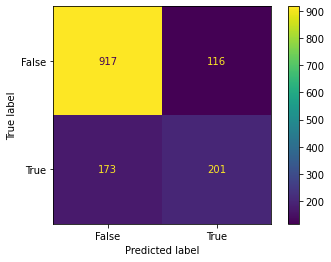

In [126]:
cm = confusion_matrix(y_test,y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display_lr.plot()
plt.show()

In [127]:
print(classification_report(y_test, y_pred_lr_smt))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



In [128]:
probs_dt_smt = model_dt_smt.predict_proba(X_test)

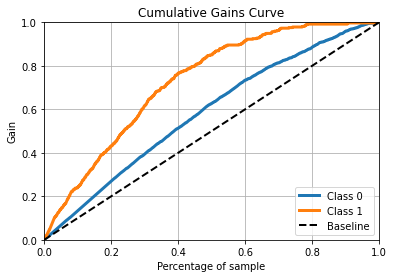

In [129]:
pcg(y_test,probs_dt_smt)
plt.show()